# Twitterのセンチメントアナリシス

http://alt.qcri.org/semeval2016/task4/index.php?id=results

https://github.com/fchollet/keras/issues/8164

Googleの(Word2vec)分散表現を利用

Tweetがポジティブか、ネガティブか、ニュートラルかを判定する

In [1]:
# 分散表現モデル
WORD2VEC_MODEL = "C:/Users/jtcuser/DeepLearning/data/GoogleNews-vectors-negative300.bin.gz"
# Twitterデータ
INPUT_FILE_TRAIN = "C:/Users/jtcuser/DeepLearning/data/Twitter2016-train.txt"
INPUT_FILE_TEST  = "C:/Users/jtcuser/DeepLearning/data/Twitter2016-test.txt"
INPUT_FILE_DEV   = "C:/Users/jtcuser/DeepLearning/data/Twitter2016-dev.txt"
# 最大語彙サイズ
VOCAB_SIZE = 20000 
# Google Newsで学習された300次元のword embedding(分散表現)
EMBED_SIZE = 300 

In [2]:
import collections
import nltk
import numpy as np
from nltk.tokenize import TweetTokenizer

print("データの読込み（1回目）：単語文字の最大長、語彙数の調査...")
counter = collections.Counter()
maxlen = 0
tweetToken = TweetTokenizer()

files = [INPUT_FILE_TRAIN, INPUT_FILE_DEV, INPUT_FILE_TEST]
for f in files:
    fin = open(f, "r")
    for line in fin:
        _, sent = line.strip().split("\t")
        words = [x.lower() for x in tweetToken.tokenize(sent)]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1
    fin.close()

print('最大単語数:',maxlen)
print("出現単語数 = ",len(counter),' ',type(counter))


データの読込み（1回目）：単語文字の最大長、語彙数の調査...
最大単語数: 55
出現単語数 =  50898   <class 'collections.Counter'>


In [3]:
print("語彙生成 creating vocabulary...")
VOCAB_SIZE = 20000 # Twitter最大語彙の設定（これ以上は無視する）
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):# 頻度順
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
index2word[0] = "_UNK_" # 未知語
# print("len(word2index) = ", len(word2index))
print("最大頻度単語 index2word[1] = ",index2word[1])

語彙生成 creating vocabulary...
最大頻度単語 index2word[1] =  the


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4  #20%
session = tf.Session(config=config)

# Kerasの定義
import keras
from keras import backend as K
K.set_session(session) 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

Using TensorFlow backend.


In [5]:
print("訓練用データの単語列生成")
xs, ys = [], []
files = [INPUT_FILE_TRAIN, INPUT_FILE_DEV] # 訓練データ＋開発データ⇒訓練データ
for f in files:
    fin = open(f, "r")
    for line in fin:
        label, sent = line.strip().split("\t")
        ys.append(int(label))
        words = [x.lower() for x in tweetToken.tokenize(sent)]
        wids = [word2index[word] for word in words]
        xs.append(wids)
    fin.close()

X_train = pad_sequences(xs, maxlen=maxlen)# パディング
Y_train = np_utils.to_categorical(ys) # ワンホットベクトル生成
print("訓練データ（データ＋ラベル）")
print("訓練データのタイプとシェープ：",X_train.dtype," ",type(X_train)," ",X_train.shape)
print("訓練ラベルのタイプとシェープ：",Y_train.dtype," ",type(Y_train)," ",Y_train.shape)
print("------------------------------------")
print("テスト用データの単語列生成")
xs, ys = [], []
fin = open(INPUT_FILE_TEST, "r")
for line in fin:
    label, sent = line.strip().split("\t")
    ys.append(int(label))
    words = [x.lower() for x in tweetToken.tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X_test = pad_sequences(xs, maxlen=maxlen)# パディング
Y_test = np_utils.to_categorical(ys)# ワンホットベクトル生成
print("テストデータ（データ＋ラベル）")
print("テストデータのタイプとシェープ：",X_test.dtype," ",type(X_test)," ",X_test.shape)
print("テストラベルのタイプとシェープ：",Y_test.dtype," ",type(Y_test)," ",Y_test.shape)


訓練用データの単語列生成
訓練データ（データ＋ラベル）
訓練データのタイプとシェープ： int32   <class 'numpy.ndarray'>   (7999, 55)
訓練ラベルのタイプとシェープ： float32   <class 'numpy.ndarray'>   (7999, 3)
------------------------------------
テスト用データの単語列生成
テストデータ（データ＋ラベル）
テストデータのタイプとシェープ： int32   <class 'numpy.ndarray'>   (20632, 55)
テストラベルのタイプとシェープ： float32   <class 'numpy.ndarray'>   (20632, 3)


In [6]:
# np.random.seed(41)

Xtrain = X_train
Xtest = X_test
Ytrain = Y_train
Ytest = Y_test

print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)


(7999, 55) (20632, 55) (7999, 3) (20632, 3)


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline 
import matplotlib.pyplot as plt
# Gensimパッケージ
from gensim.models import KeyedVectors

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import LSTM # GPUがある場合　CuDNNLSTM
from keras.layers import Bidirectional


In [8]:
# 大規模なデータファイルのロード： 時間かかります

word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)
embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass
    

In [9]:
# 1次元の畳込み（モデル１）

NUM_FILTERS = 128 # フィルター数
NUM_WORDS = 5 # 単語数

model1 = Sequential()
model1.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen, 
                     weights=[embedding_weights], # 初期値をGoogleの分散表現にする      
                     trainable=True))
model1.add(SpatialDropout1D(0.1)) # 10%ドロップアウト
model1.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(3, activation="softmax"))

model1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 300)           6000300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 55, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 128)           192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 6,192,815
Trainable params: 6,192,815
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 再帰型ニューラルネット（モデル２）

HIDDEN_LAYER_SIZE = 50  
model2 = Sequential()
model2.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen, 
                     weights=[embedding_weights], 
                     trainable=True))
model2.add(SpatialDropout1D(0.1)) # 10%
model2.add(Bidirectional(LSTM(HIDDEN_LAYER_SIZE))) # GPUがあればCuDNNLSTM
model2.add(Dense(3, activation="softmax"))
model2.summary()
           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 55, 300)           6000300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 55, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 6,141,003
Trainable params: 6,141,003
Non-trainable params: 0
_________________________________________________________________


In [11]:
myComp1 = model1.compile(
    optimizer="adadelta", 
    loss="categorical_crossentropy",
    metrics=["accuracy"])


In [12]:
myComp2 = model2.compile(
    optimizer="adadelta", 
    loss="categorical_crossentropy",
    metrics=["accuracy"])


In [13]:
NUM_EPOCHS = 4
BATCH_SIZE = 32 # バッチサイズ
history1 = model1.fit(
    Xtrain, Ytrain, 
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(Xtest, Ytest))


Train on 7999 samples, validate on 20632 samples
Epoch 1/4
7999/7999 [==============================] - 44s 6ms/step - loss: 0.9135 - acc: 0.5526 - val_loss: 0.8580 - val_acc: 0.5737
Epoch 2/4
7999/7999 [==============================] - 44s 6ms/step - loss: 3.5483 - acc: 0.5751 - val_loss: 10.6028 - val_acc: 0.3421
Epoch 3/4
7999/7999 [==============================] - 44s 5ms/step - loss: 8.1850 - acc: 0.4922 - val_loss: 10.6028 - val_acc: 0.3421
Epoch 4/4
7999/7999 [==============================] - 44s 5ms/step - loss: 8.1850 - acc: 0.4922 - val_loss: 10.6028 - val_acc: 0.3421


In [14]:
NUM_EPOCHS = 8 # エポック
BATCH_SIZE = 64 # バッチは64
history2 = model2.fit(
    Xtrain, Ytrain, 
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(Xtest, Ytest))

Train on 7999 samples, validate on 20632 samples
Epoch 1/8
7999/7999 [==============================] - 39s 5ms/step - loss: 0.9727 - acc: 0.5073 - val_loss: 1.1978 - val_acc: 0.3538
Epoch 2/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.8730 - acc: 0.5813 - val_loss: 0.8815 - val_acc: 0.5704
Epoch 3/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.8132 - acc: 0.6220 - val_loss: 0.8576 - val_acc: 0.5795
Epoch 4/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.7687 - acc: 0.6448 - val_loss: 0.8703 - val_acc: 0.5585
Epoch 5/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.7368 - acc: 0.6650 - val_loss: 0.8944 - val_acc: 0.5456
Epoch 6/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.6993 - acc: 0.6866 - val_loss: 0.8990 - val_acc: 0.5750
Epoch 7/8
7999/7999 [==============================] - 36s 5ms/step - loss: 0.6652 - acc: 0.7076 - val_loss: 0.9245 - val_acc: 0.5539
Epoch 8/8
799

In [15]:
pred_1 = model1.predict(Xtest)
pred_2 = model2.predict(Xtest)

In [16]:
# Conv1D + LSTM
mix_pred = pred_1 * pred_2
print(mix_pred.shape)


(20632, 3)


In [17]:
print(mix_pred)

[[4.3638928e-16 9.4531845e-14 5.8948976e-01]
 [1.5395193e-16 5.6752048e-14 6.3835377e-01]
 [3.1688297e-15 3.0580017e-13 1.6436520e-01]
 ...
 [2.3709450e-13 3.4762575e-12 8.5228041e-02]
 [8.7758823e-16 1.4702578e-14 4.0304682e-01]
 [2.5736288e-14 7.0794749e-14 2.7260467e-01]]


In [18]:
# 確率が最大となるクラスに分類し、ワンホットベクトルを生成
total = X_test.shape[0]
mix_pred_class = np.zeros((total,3),dtype=int)
for i in range(total):
    my = np.argmax(mix_pred[i])
    mix_pred_class[i][my] = 1

print(mix_pred_class)


[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [19]:
mix_prediction = np.zeros((total),dtype=int)
for i in range(total):
    my = np.argmax(mix_pred_class[i])
    mix_prediction[i] = my
print(mix_prediction)

[2 2 2 ... 2 2 2]


In [20]:
# 最終的な精度を簡単なループで計算
count = 0
y_actual = np.argmax(Ytest, axis=1)
print(y_actual.shape)
total_y = y_actual.shape[0]
for i in range(total_y):
    if y_actual[i] == mix_prediction[i]: # 正解と一致するものをカウント
        count += 1
accuracy = float(count)/total_y # テストのデータ総数から精度を計算
print("accuracy = ",accuracy) # 最終的なクラス全体の平均精度のプリント


(20632,)
accuracy =  0.34213842574641334


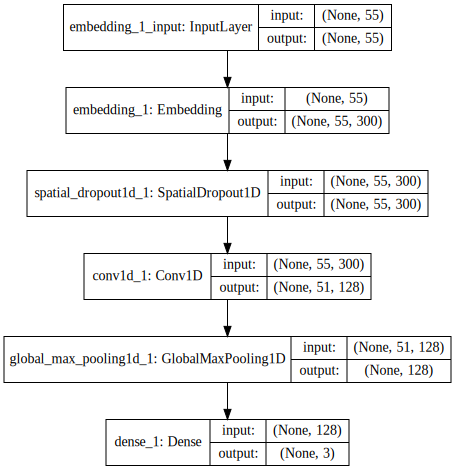

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(model1, show_shapes=True, to_file='images/Python-Twitter-CNN.jpg')

SVG(model_to_dot(model1,show_shapes=True).create(prog='dot', format='svg'))


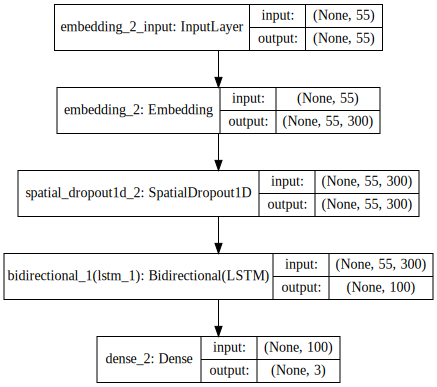

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True, to_file='images/Python-Twitter-LSTM.jpg')

SVG(model_to_dot(model2,show_shapes=True).create(prog='dot', format='svg'))


In [23]:
model1.save("h5/Python-Twitter-Conv1D.h5") # 訓練されたモデル
model1.save_weights('h5/Python-Twitter-Conv1D-weights.h5')
model2.save("h5/Python-Twitter-LSTM.h5") # 訓練されたモデル
model2.save_weights('h5/Python-Twitter-LSTM-weights.h5')

In [24]:
# pickleでセーブ
import pickle
with open('pkl/Python-Twitter-Conv1D.pkl', 'wb') as h_file:
    pickle.dump(history1.history, h_file)
with open('pkl/Python-Twitter-LSTM.pkl', 'wb') as h_file:
    pickle.dump(history2.history, h_file)

In [25]:
# JSONへ保存
json_str = model1.to_json()
open('json/Python-Twitter-Conv1D.json','w').write(json_str)
json_str = model2.to_json()
open('json/Python-Twitter-LSTM.json','w').write(json_str)

2112

In [26]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


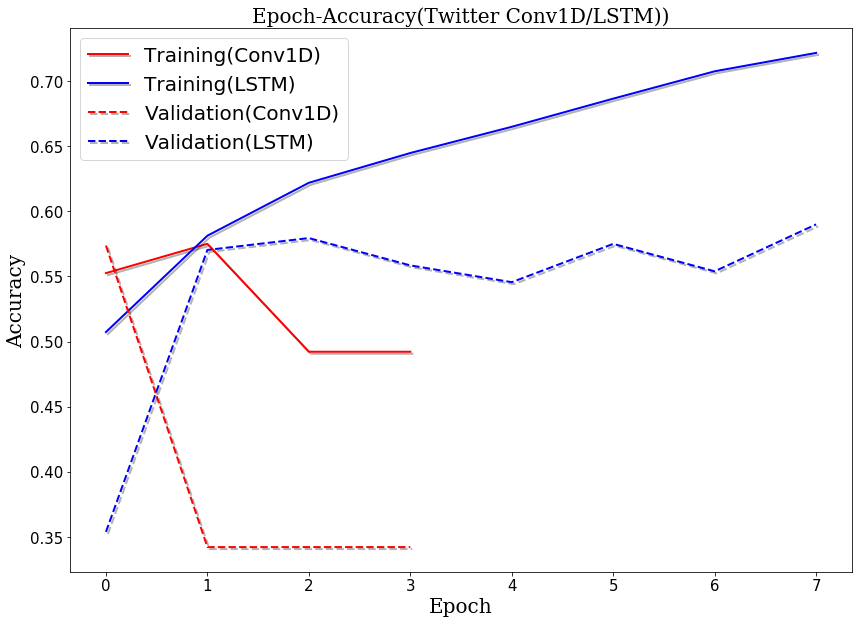

In [27]:
# 精度グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history1.history['acc'], 
         color='r', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history2.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history1.history['val_acc'], 
         color='r', 
         linestyle='--',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history2.history['val_acc'], 
         color='b', 
         linestyle='--',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.tick_params(labelsize=15)
plt.title('Epoch-Accuracy(Twitter Conv1D/LSTM))',fontsize=20,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Training(Conv1D)', 
            'Training(LSTM)',
            'Validation(Conv1D)',
            'Validation(LSTM)'], loc='best', fontsize=20)
plt.savefig('pdf/Epoch-Acc-Twitter-Conv1D-LSTM.pdf')
plt.show()

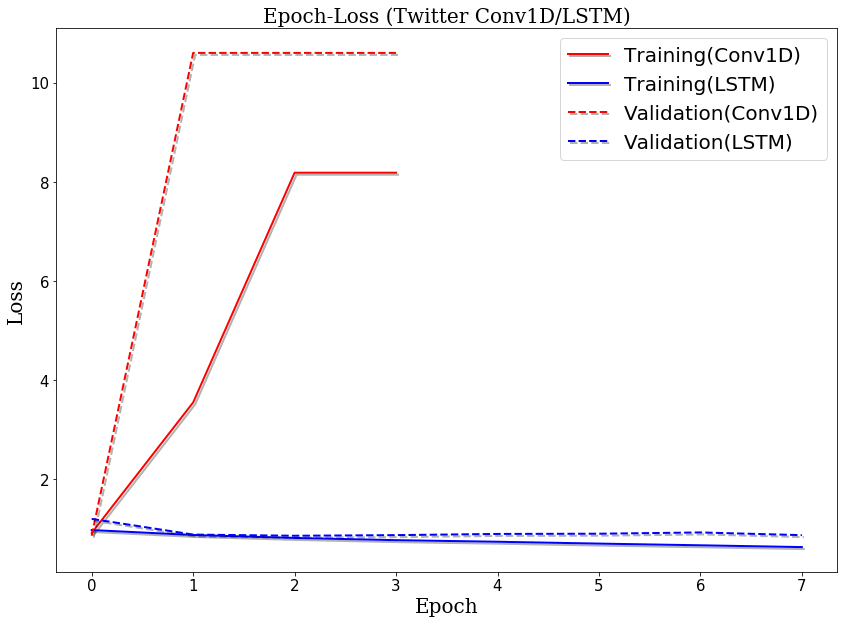

In [28]:
# 損失グラフの描画
plt.figure(figsize=(14,10))
#plt.plot(history.history['loss'], color='b', linestyle='-')
#plt.plot(history.history['val_loss'], color='g', linestyle='--')

plt.plot(history1.history['loss'], 
         color='r', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history2.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=2, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history1.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history2.history['val_loss'], 
         color='b', 
         linestyle='--',
         linewidth=2,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.tick_params(labelsize=15)

plt.title('Epoch-Loss (Twitter Conv1D/LSTM)',fontsize=20,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Training(Conv1D)', 
            'Training(LSTM)',
            'Validation(Conv1D)',
            'Validation(LSTM)'], loc='best', fontsize=20)
plt.savefig('pdf/Epoch-Loss-Twitter-Conv1D-LSTM.pdf')
plt.show()

In [29]:
score1 = model1.evaluate(Xtest, Ytest, verbose=1)
score2 = model2.evaluate(Xtest, Ytest, verbose=1)
print("\nTest score (Conv1D): {:.3f}, accuracy: {:.3f}".format(score1[0], score1[1]))
print("\nTest score (LSTM): {:.3f}, accuracy: {:.3f}".format(score2[0], score2[1]))

20632/20632 [==============================] - 11s 545us/step

Test score (Conv1D): 10.603, accuracy: 0.342

Test score (LSTM): 0.870, accuracy: 0.590


In [30]:
from sklearn.metrics import classification_report,confusion_matrix

#y_pred2 = model.predict(Xtest)
y_pred = mix_pred
y_pred2 = np.argmax(y_pred, axis=1)

y_actual = np.argmax(Ytest, axis=1)

cm = confusion_matrix(y_pred2, y_actual)


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

Confusion matrix, without normalization
[[    0     0     0]
 [    0     0     0]
 [ 3231 10342  7059]]


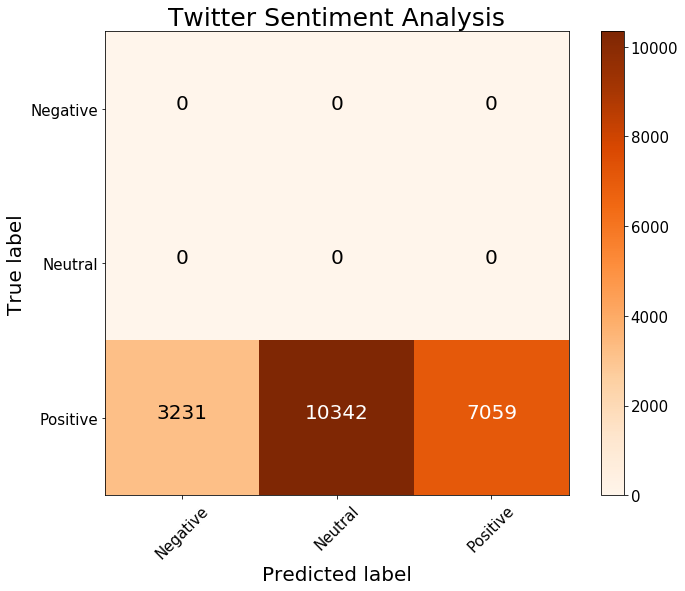

In [34]:
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm, classes=classes, title='Twitter Sentiment Analysis')
plt.show()

In [33]:
# F1-measures
count = 0
total = y_actual.shape[0]
PP = PU = PN = UP = UU = UN = NP = NU = NN = 0
for i in range(total):
    p,a = y_pred2[i],y_actual[i]
    if p==2:
        if a==0:
            PN += 1
        elif a==1:
            PU += 1
        else:
            PP += 1
    elif p==1:
        if a==0:
            UN += 1
        elif a==1:
            UU += 1
        else:
            UP += 1
    else:
        if a==0:
            NN += 1
        elif a==1:
            NU += 1
        else:
            NP += 1
    count += 1

precision_positive = float(PP)/(PP+PU+PN)
recall_positive = float(PP)/(PP+UP+NP)
precision_negative = float(NN)/(NP+NU+NN)
recall_negative = float(NN)/(PN+UN+NN)
precision_neutral = float(UU)/(UP+UU+UN)
recall_neutral = float(UU)/(PU+UU+NU)
F1_positive = (2 * precision_positive * recall_positive)/(precision_positive + recall_positive) 
F1_negative = (2 * precision_negative * recall_negative)/(precision_negative + recall_negative)
F1_neutral = (2 * precision_neutral * recall_neutral)/(precision_neutral + recall_neutral)
F1_PN = 0.5 * (F1_positive + F1_negative)
print("PP = ",PP," NN = ",NN," UU = ",UU)
print("F1_positive（ポジティブのF1値） = ",F1_positive)
print("F1_negative （ネガティブのF1値）= ",F1_negative)
print("F1_neutral = （ニュートラルのF1値）",F1_neutral)
print("F1_PN = ",F1_PN)
accuracy = float(PP+UU+NN)/total # テストのデータ総数から精度を計算
print("分類精度 = ",accuracy) # 最終的なクラス全体の平均精度のプリント


ZeroDivisionError: float division by zero

In [47]:
# 最終的な精度を簡単なループで計算
count = 0
total = y_actual.shape[0]
for i in range(total):
    if y_actual[i] == y_pred2[i]: # 正解と一致するものをカウント
        count += 1
accuracy = float(count)/total # テストのデータ総数から精度を計算
print("accuracy = ",accuracy) # 最終的なクラス全体の平均精度のプリント


accuracy =  0.5813299728576968
